# Model Interpretability using LIME and SHAP
Dennis Tseng <br>
DSC 672 - Software Presentation

So you've built a model and got it to perform at a high accuracy... but then your boss tells you to explain why it's making certain predictions. You bring up the feature importances, but he counters with "so for *this* variable, are you telling me the higher this variable is, the more likely it predicts a certain class?" You realize that this is *not* what feature importances are telling you, and you start sweating because you don't have a good answer for his question...

## Why is interpretability important?

Here are just a few examples of why model interpretability is important:
- Bias in Data (Promotions and salaries at a company tend to favor men vs women)
- Right to know (GDPR)
- Understand edge cases and situation where model fails

Here's an example from the LIME paper (https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) by Ribiero et al. that highlights one of the pitfalls of black box models. Say we've built a model that tries to predict whether an animal is a husky or wolf. We build a model that is super accurate, but when we use LIME or SHAP, we actually find out that rather than being able to identify the peculiarities of both animals, the model is instead searching for whether or not the image has snow in it!
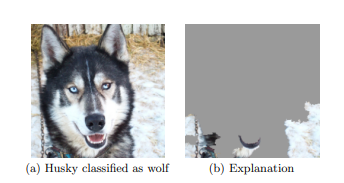

I think we've highlighted why performance metrics like 'accuracy' are not sufficient to determine whether or not a model is performant. This is where LIME and SHAP come in. 

## The LIME and SHAP Approach

LIME and SHAP create surrogate models that attempt to explain changes in the prediction of the base model. That is, it attempts to use a simpler model to establish the relationship between input changes affect the overall prediction. The main benefit to this approach is that the use of these approache is thus *model agnostic*. You can use them with any model, provided that the LIME and SHAP packages are able to support/understand the format of the model.

In this Jupyter Notebook, we're going to explain a bit of how both approaches work, the pros and cons of each technique, as well as walk through examples using the highly popular iris dataset.

## LIME

LIME, or Local Interpretable Model-Agnostic Explanations, provides why a single observation/row/data point was predicted to be a certain class.

Paper: 
https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf <br>
Package: 
https://github.com/marcotcr/lime

pip install lime

### Intuition 

The following image attempts to highlight how LIME tries to explain predictions from the base model. For any observation (blue), LIME randomly samples data whose values are locally similar/close to the original dataset. Then, it creates a linear regression model that will thus model how changes in feature values affect the probability of a given prediction. We note that this is local, and the effects do not apply globally. As seen in the higher sat score, the linear regression line is much flatter than if the SAT score was lower:

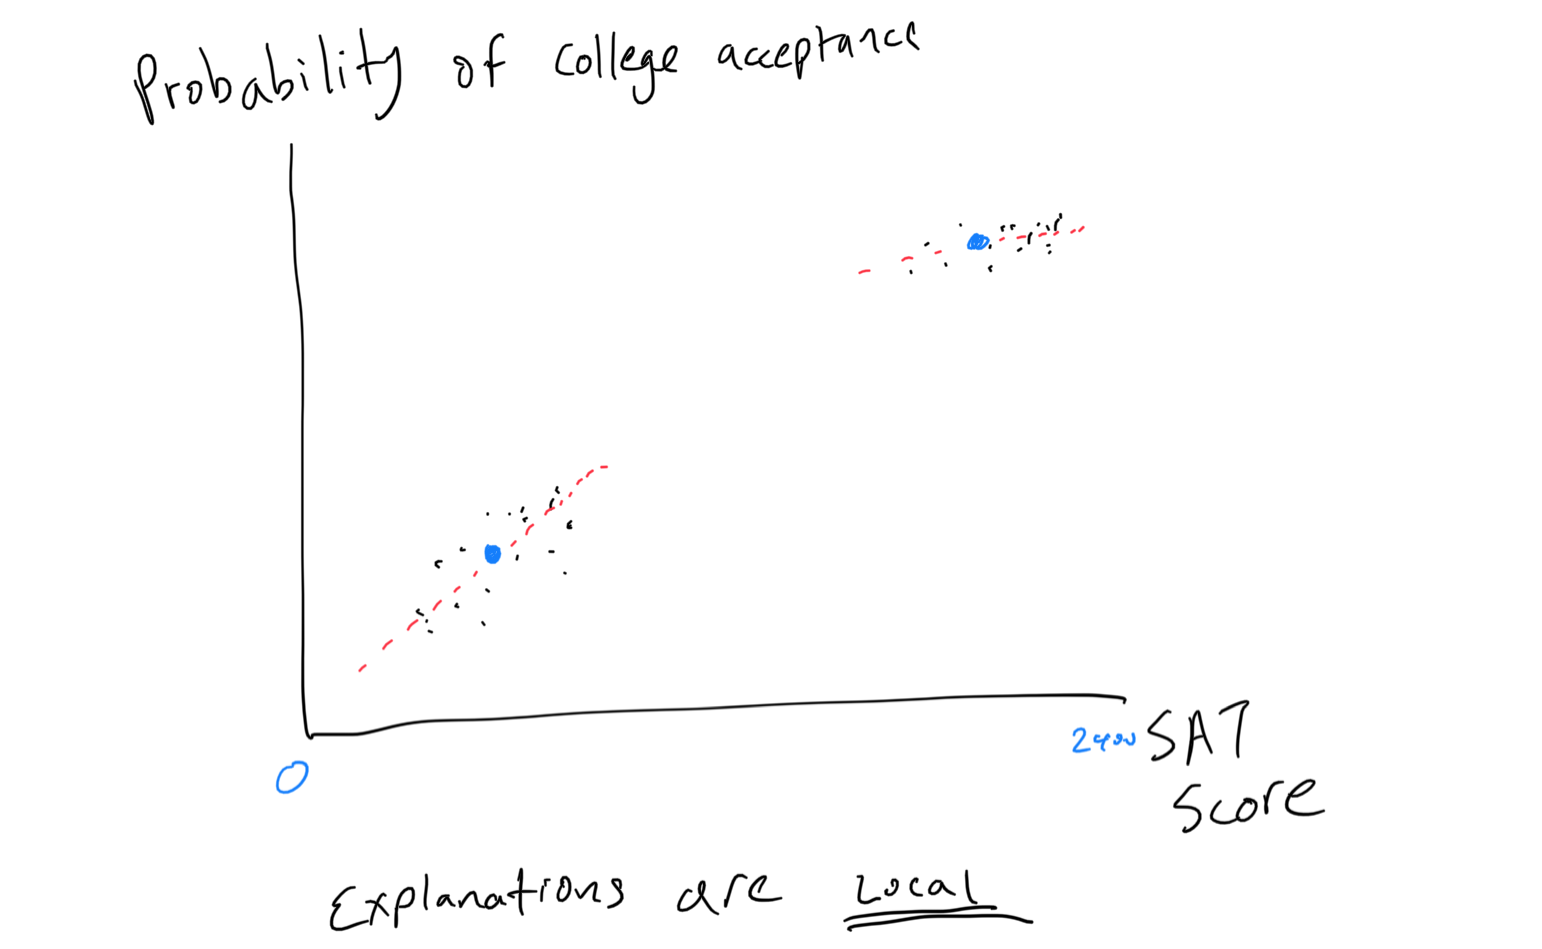

The following image, pulled from the above paper, shows how this hyper-local approach can tackle models that are not linear in nature. The red and blue colors represent different class predictions. The bolded red plus symbol represents the observation, where there is a fitted regression line to explain just that one point:

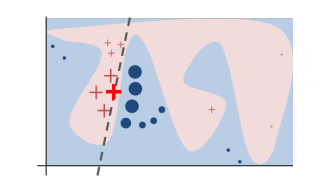


### Pros and Cons

Pros
- Model agnostic. Can support a wide range of data (images too!)
- Model interpretability

Cons
- Local interpretability ONLY
- Can be unstable due to the random sampling of points to generate linear model
- Fit of linear model can be bad depending on data
- Can be slow

## SHAP

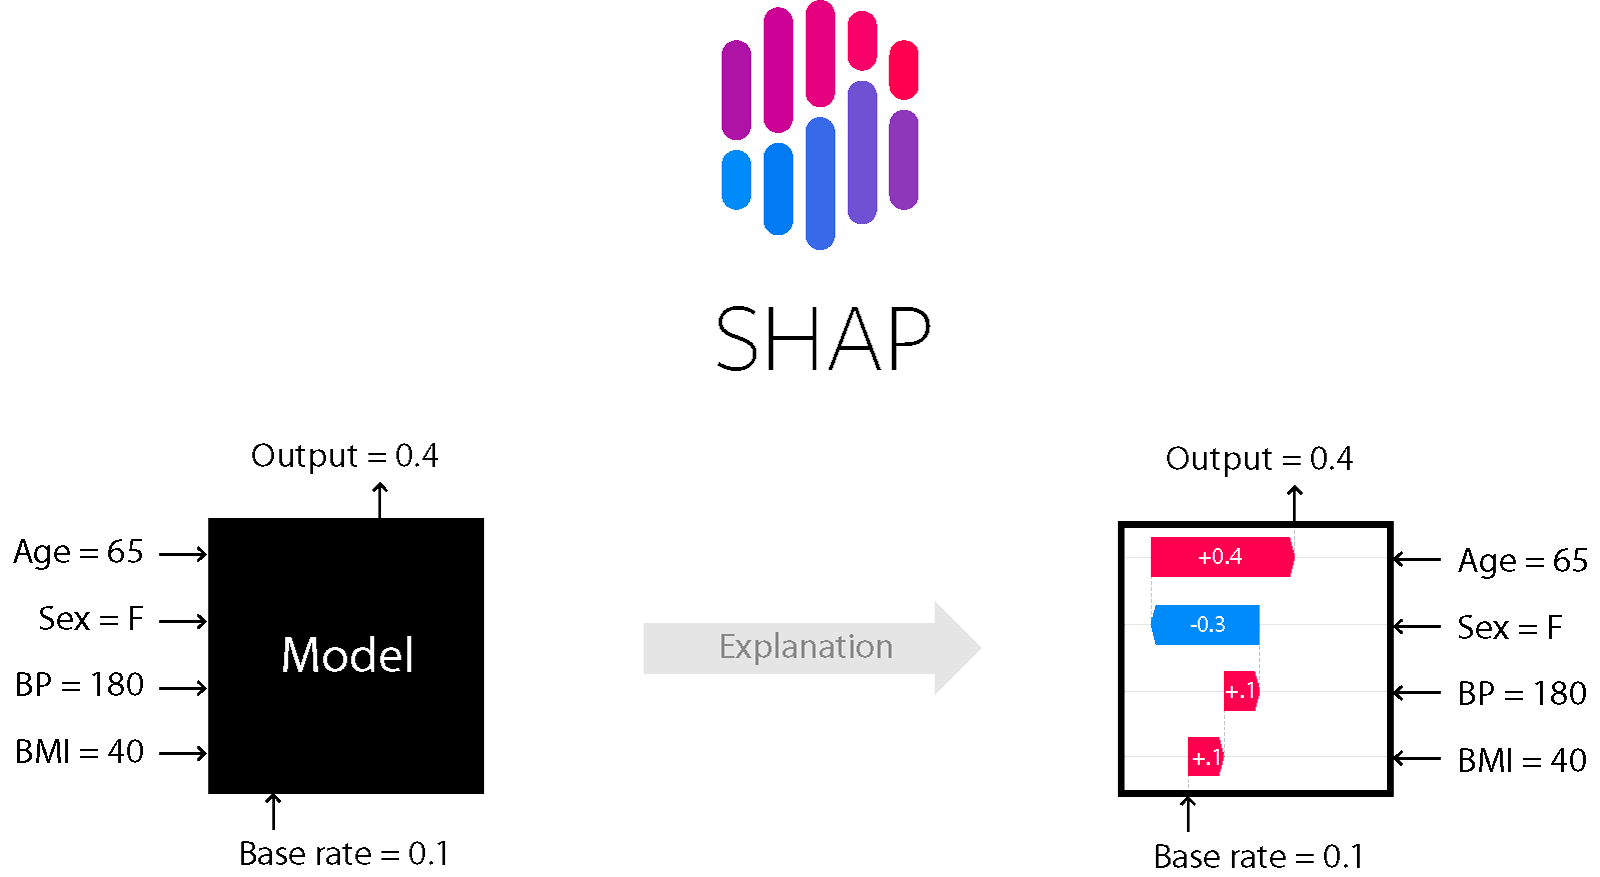
*Image source: SHAP site*

Paper: 
https://arxiv.org/pdf/1705.07874.pdf <br>
Package: 
https://github.com/slundberg/shap

pip install shap

### Intuition 

The fundamental concept that SHAP uses to calculate the weight (importance) of each feature is the 'Shapley value.' In the context of a model and the features in the data, a Shapley value is the average expected marginal contribution of a feature after considering all possible combinations of features. 

In detail, for a feature X{i}:
- Get all subset of features S that do not contain X{i}
- Compute the effect on predictions of adding X{i} to every subset

Interesting tidbit: LIME is actually a subset of SHAP!

### Pros and Cons

Pros
- Model agnostic. Can support a wide range of data
- Optimized for tree methods, but supports TensorFlow, Keras, SKLearn
- Model interpretability
- Global and Local interpretability
- Wide range of visualisation options

Cons
- Due to the need to calculate effect for every subset of features, is even more computatationally expensive than LIME

Image Example:
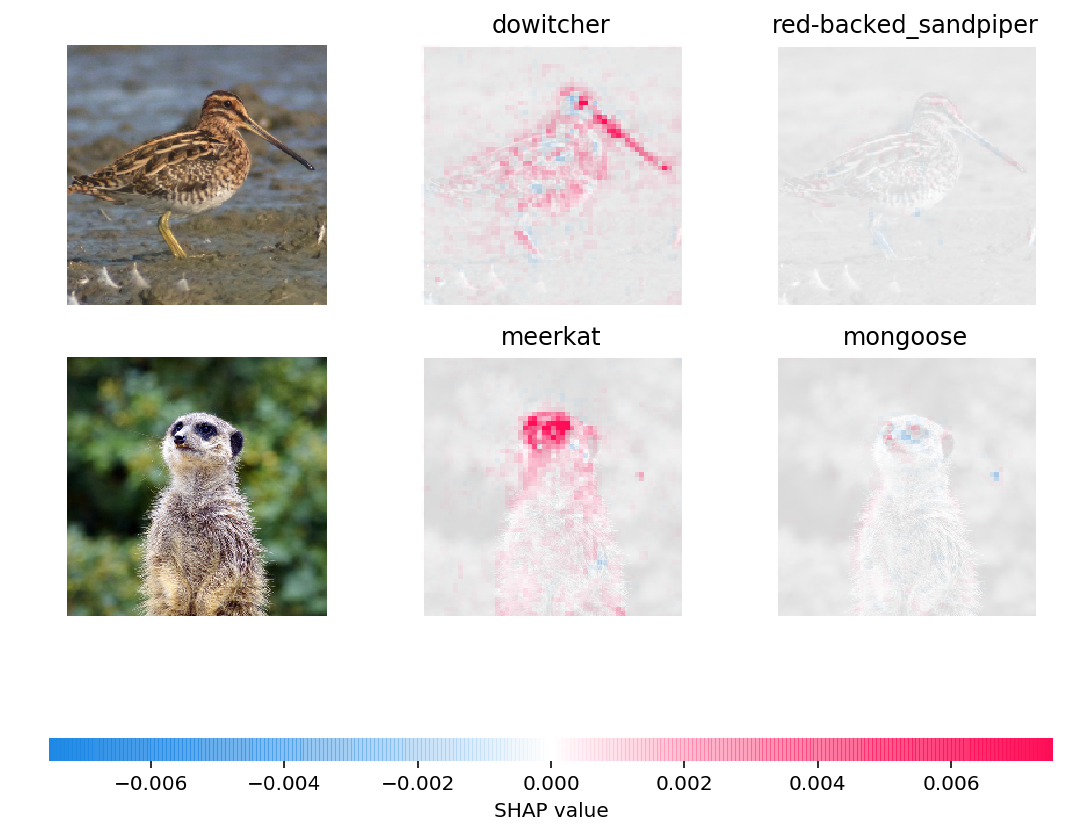


# In Practice:

## Load Packages and Data First...

In [1]:
# Load required packages
from sklearn import datasets
import pandas as pd
import numpy as np
import lime
import shap
shap.initjs()

In [2]:
datasets.load_iris().target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [3]:
# Load Iris Dataset as an example:
iris = datasets.load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
target.value_counts()

NameError: name 'target' is not defined

## LIME Example

First, let's train a random forest classifier:

In [173]:
# Load packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

target = iris['target']
del iris['target']

# Split target and train
X_train,X_test,y_train,y_test = train_test_split(iris,target,test_size=0.3)

# Our random forest classifier
rf_model_lime = RandomForestClassifier(random_state = 0)
rf_model_lime.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Now, we create a LIME explainer:

In [174]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values,
                                 mode="classification",
                                 feature_names=X_train.columns,
                                 random_state=0)


def prob(data):
    return np.array(list(zip(1-rf_model_lime.predict(data),rf_model_lime.predict(data))))

And that's it. Now we can start looking at individual observations we want to explain:

In [87]:
# Pick the 21st observation

print("Observation feature values:\n",X_test.iloc[20],"\n")
print("True label:\n",y_test.iloc[20])

test_observation = X_test.iloc[[20],:]

print(rf_model_lime.predict_proba(test_observation)[0])
print(rf_model_lime.predict(test_observation)[0])

Observation feature values:
 sepal length (cm)    6.9
sepal width (cm)     3.2
petal length (cm)    5.7
petal width (cm)     2.3
Name: 120, dtype: float64 

True label:
 2.0
[0. 0. 1.]
2.0


In [76]:
#Call explain_instance to show explanation. For multi-class problems it will highlight the probability that it is class label 2
#vs not class 2

explanation = explainer.explain_instance(test_observation.values[0], prob)
explanation.show_in_notebook(show_table=True, show_all=False)

We can see from this that petal length, width, and sepal length contribute to the explaniner calling this true label 2 (virginica). Only sepal length pushes it towards 'not Virginica'

Say we didn't want to show in a jupyter notebook and we want to generate this to a dataframe and export it for, say, use in Tableau. We can do the following:

In [82]:
explanation.as_list()

[('petal length (cm) > 5.10', 1.040791350012753),
 ('petal width (cm) > 1.80', 0.21889458221272384),
 ('sepal length (cm) > 6.40', 0.17865265714143413),
 ('3.00 < sepal width (cm) <= 3.30', -0.057493532074383465)]

What's important to note is that the labels will not be global, as each label includes thresholds used to make such distinctions.

Since LIME is fitting a linear model on a sample of the data, we can take a look at the coefficients, intercept, and the R^2 to see if this is a good enough explanation:

In [80]:
print("Coefficients: ", explanation.local_exp)
print("Intercept: ", explanation.intercept)
print("R^2: ", explanation.score)

Coefficients:  {1: [(2, 1.040791350012753), (3, 0.21889458221272384), (0, 0.17865265714143413), (1, -0.057493532074383465)]}
Intercept:  {1: 0.682504800606063}
R^2:  0.36619486982371974


So, in this case, since the R^2 is not that high, perhaps we don't necessarily want to trust this explanation. Granted, we didn't tune the model, dataset size and feature distributions will also need to be considered.

## SHAP Example

In [177]:
# New RF instance just for completeness:

# Our random forest classifier
rf_model_shap = RandomForestClassifier(random_state = 0)
rf_model_shap.fit(X_train, y_train)


# Create the explainer on the existing rf model
shap_explainer = shap.TreeExplainer(rf_model_shap)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [178]:
# Pick the 1st observation

print("Observation feature values:\n",X_train.iloc[0],"\n")
print("True label:\n",y_train.iloc[0])

train_observation = X_train.iloc[[0],:]

print(rf_model_lime.predict_proba(train_observation)[0])
print(rf_model_lime.predict(train_observation)[0])

Observation feature values:
 sepal length (cm)    5.1
sepal width (cm)     3.3
petal length (cm)    1.7
petal width (cm)     0.5
Name: 23, dtype: float64 

True label:
 0.0
[1. 0. 0.]
0.0


### Local Interpretability

In order to compute shapley values with TreeExplainer, we call the shap_values method while passing the original training dataset.

In [195]:
shap_values = shap_explainer.shap_values(X_train)[0]

Now we can visualize explanations using force_plot:

In [189]:
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_train.columns)

If we want to just output the shap values somewhere, we can look at that just the row that corresponds to the observation. Looking at the first observation, we see the shap values below. Note that if you add all of this up along with the base value (0.3294), this exactly matches that of the label probability for that is outputted by the random forest predict_prob output above:

In [187]:
shap_values[0]

array([0.05628865, 0.00597371, 0.30219093, 0.27107052])

### Global Interpretability

SHAP can also plot all of the shap values for every observation in a single force plot:

In [190]:
global_shap_values = shap_explainer.shap_values(X_train)

In [191]:
i = 0
shap.force_plot(shap_explainer.expected_value[i], global_shap_values[i], features=X_train, link="logit")

To export all of the shap values for all of the features per observation, we can then just export from the shap_values array, and we see that they correspond to the values for all of the features for each observation in the dataset you've fed it:

In [167]:
global_shap_values[0]

array([[ 8.63698868e-02, -1.10601163e-02,  3.06443219e-01,
         2.78818439e-01],
       [-2.81870578e-02, -5.57634596e-03, -1.59756381e-01,
        -1.35908786e-01],
       [-3.43702849e-02,  3.21759513e-04, -1.60938964e-01,
        -1.34441082e-01],
       [-3.66308000e-02, -5.79651617e-04, -1.59999541e-01,
        -1.32218579e-01],
       [ 8.26433380e-02,  7.12626885e-03,  3.04341527e-01,
         2.76460295e-01],
       [ 8.84181396e-02,  1.36535615e-03,  3.04341527e-01,
         2.76446406e-01],
       [-3.63171190e-02, -8.89553356e-04, -1.59999541e-01,
        -1.32222358e-01],
       [-3.19749292e-02, -1.56522903e-03, -1.59986278e-01,
        -1.35902135e-01],
       [ 8.31641714e-02,  6.39710219e-03,  3.04341527e-01,
         2.76668628e-01],
       [-3.19749292e-02, -1.56522903e-03, -1.59986278e-01,
        -1.35902135e-01],
       [ 8.31641714e-02,  6.39710219e-03,  3.04341527e-01,
         2.76668628e-01],
       [-3.41586447e-02,  2.15939407e-04, -1.60938964e-01,
      

If we want to look at how each feature contributes to predicting each class, we can call the following (this will look different for binary class problems!)

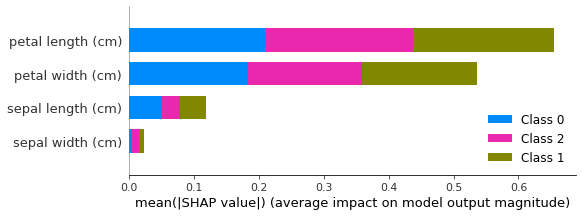

In [169]:
shap.summary_plot(global_shap_values, X_train, plot_type="bar")